# Solving classification problems with CatBoost

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb)

In this tutorial we will use dataset Amazon Employee Access Challenge from [Kaggle](https://www.kaggle.com) competition for our experiments. Data can be downloaded [here](https://www.kaggle.com/c/amazon-employee-access-challenge/data).

## Libraries installation

In [1]:
#!pip install --user --upgrade catboost
#!pip install --user --upgrade ipywidgets
#!pip install shap
#!pip install sklearn
#!pip install --upgrade numpy
#!jupyter nbextension enable --py widgetsnbextension

In [1]:
import catboost
print(catboost.__version__)
!python --version

0.26.1
Python 3.9.12


## Reading the data

In [2]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

In [3]:
(train_df, test_df) = catboost.datasets.amazon()
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
train_df.shape

(32769, 10)

## Preparing your data

Label values extraction

In [5]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Looking on label balance in dataset

In [6]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)


## Feature importances

In [8]:
model = catboost.CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.6569860	total: 84ms	remaining: 16.7s
50:	learn: 0.1907871	total: 611ms	remaining: 1.78s
100:	learn: 0.1645125	total: 1.34s	remaining: 1.32s
150:	learn: 0.1565519	total: 2.17s	remaining: 704ms
199:	learn: 0.1533854	total: 3.04s	remaining: 0us


Source [video](https://youtu.be/xl1fwCza9C8?t=3482)

Use function `get_feature_importance` with the following parameters:

* `type`, [docs](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_get_feature_importance#type)
    * `FeatureImportance` -  Equal to [PredictionValuesChange](https://catboost.ai/en/docs/concepts/fstr#regular-feature-importance) for non-ranking metrics (default)
        - For each feature, PredictionValuesChange shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.
    * `ShapValues` - A vector vv with contributions of each feature to the prediction for every input object and the expected value of the model prediction for the object
    * `Interaction` - The value of the feature interaction strength for each pair of features.
    * `PredictionDiff` - A vector with contributions of each feature to the RawFormulaVal difference for each pair of objects.
* `prettified` - Return the feature importances as a list of the following pairs sorted by feature importance. Should be used if `type=PredictionValueChange`.

In [9]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RESOURCE,22.311819
1,MGR_ID,18.121045
2,ROLE_DEPTNAME,14.891573
3,ROLE_ROLLUP_2,12.310360
4,ROLE_CODE,10.388989
5,ROLE_FAMILY_DESC,9.144182
6,ROLE_TITLE,6.402628
7,ROLE_FAMILY,4.649123
8,ROLE_ROLLUP_1,1.780282


## Shap values

Here we have information for each object in the train dataset. `get_feature_importance(data=X)` returns `np.array` of shape `(n_objects, n_features + 1)` with float ShapValues for each `(object, feature)`.

In [14]:
shap_values = model.get_feature_importance(
    data=Pool(data=X, label=y, cat_features=cat_features), 
    type='ShapValues'
)
shap_values.shape

(32769, 10)

Here we have additional last column which corresponds to expected value of the model prediction.

In [32]:
shap_values[:, -1]

array([3.4252, 3.4252, 3.4252, ..., 3.4252, 3.4252, 3.4252])

 All the values in this column are the same.

In [33]:
np.all(shap_values[:,-1] == shap_values[0,-1])

True

In [34]:
shap_values = shap_values[:,:-1]
expected_value = shap_values[0,-1]

Visualize feature importance using shap library. Here we look at feature importance for 3rd object. Here we see that `ROLE_DEPTNAME` and `ROLE_ROLLUP` positivelly contributes to the decision, but `ROLE_CODE` contributes negativelly.

In [35]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

Feature importance for object 91.

In [36]:
shap.force_plot(expected_value, shap_values[91,:], X.iloc[91,:])

We can visualize feature importance for multiple objects.

In [37]:
X_small = X.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, X_small)

Here for each feature we have $N$ dots, for each object. If the dot is to the left from the vertical line this means that this feature is "negative" for the predicted class. The wider the line of dots is the more important this feature for some object.

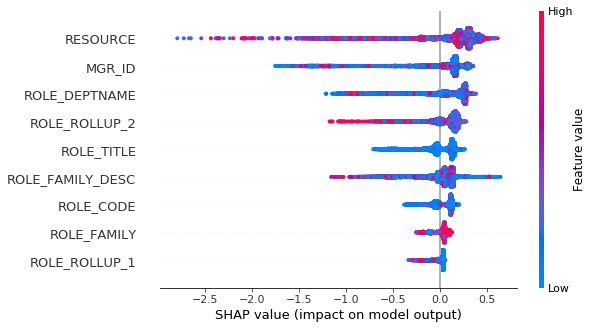

In [54]:
shap.summary_plot(shap_values, X)

## Feature evaluation

Sometimes we engineer new features and want to know if theese features are good or bad. So train a model with and without theese features and then look if the Logloss has changed. [Docs](https://github.com/catboost/catboost/tree/master/catboost/python-package/catboost/eval)

In [25]:
from catboost.eval.catboost_evaluation import CatboostEvaluation

learn_params = {
    'iterations': 20, # 2000
    'learning_rate': 0.5, # we set big learning_rate,because we have small number of iterations
    'random_seed': 0,
    'verbose': False,
    'loss_function' : 'Logloss',
    'boosting_type': 'Plain'
}

evaluator = CatboostEvaluation(
    'amazon/train.tsv',
    fold_size=10000, # <= 50% of dataset
    fold_count=20,  # cross-validation, we will train model 20 times with and without given feature
    column_description='amazon/train.cd',
    partition_random_seed=0,
    #working_dir=... 
)

# here it is important to pass indices of the features, that we want to eval
# we will eval using Logloss and Accuracy
result = evaluator.eval_features(
    learn_config=learn_params,
    eval_metrics=['Logloss', 'Accuracy'],
    features_to_eval=[1, 2, 3, 6, 7, 8]
)

/opt/anaconda3/envs/catboost/lib/python3.9/site-packages/catboost/eval/evaluation_result.py:93: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._fold_metric = pd.Series()
/opt/anaconda3/envs/catboost/lib/python3.9/site-packages/catboost/eval/evaluation_result.py:94: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._fold_metric_iteration = pd.Series()
/opt/anaconda3/envs/catboost/lib/python3.9/site-packages/catboost/eval/evaluation_result.py:93: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._fold_metric = pd.Series()
/opt/anaconda3/envs/catboost/lib/python3.9/site-packages/catboost/eval/evaluation_result.py:94: FutureWarning: The de

[Docs](https://github.com/catboost/catboost/blob/master/catboost/python-package/catboost/eval/evaluation_result.py)

Now we can view results for each feature.
* `Decision` will summarize if this feature is good/bad/unknown for the model
* `Score` how Logloss changed on average
* `Pvalue` probability that Logloss will change by the given Score if the feature is not important. So if this probability is low, more important the feature is.

ScoreConfig, Config to present human-friendly evaluation results, params:
* `score_type=ScoreType.Rel`: type of score. 
    * For abs difference score will be `(baseline - test).mean()`, for relative it's `((baseline - test) / baseline).mean()`
* `multiplier=100`: multiplier to print score
* `score_level=0.01`: WX-test level. Will be used to make if tested case significantly better or worse
* `interval_level=0.01`: level to compute score confidence interval
* `overfit_iterations_info=True`: if information about overfit iterations should be preserved

In [29]:
from catboost.eval.evaluation_result import ScoreType, ScoreConfig

# metric_result = result.get_metric_results('Logloss')
metric_result = result.get_metric_results('Accuracy')
metric_result.get_baseline_comparison(
    ScoreConfig(
        ScoreType.Abs,  # Relative Difference and AbsoluteDiff
        overfit_iterations_info=False
    )
)

,PValue,Score,Quantile 0.005,Quantile 0.995,Decision
Features: 8,0.344306,-0.002635,-0.016250,0.013615,UNKNOWN
Features: 7,0.849817,-0.001318,-0.014493,0.010980,UNKNOWN
Features: 2,0.122095,0.010760,-0.006368,0.027669,UNKNOWN
Features: 6,0.058288,0.020862,-0.003074,0.043919,UNKNOWN
Features: 3,0.000539,0.039088,0.016909,0.070491,GOOD
Features: 1,0.000089,0.080812,0.050727,0.112434,GOOD
